## Theory
(taken from the fenics book)

We are solving the Helmholtz equation:
                       

 $$\nabla \times \frac{1}{\mu_r}\nabla \times \boldsymbol{E} - k_0^2 \epsilon_r \boldsymbol{E}=0,$$ with the boundary condition of electric mirrors.
 $$k_0 = \frac{2\pi f_0}{c_0}$$
 
 $$\epsilon_r = (n+\mathrm{i}k)^2$$

The functional is:
$$F(\boldsymbol{E}) = \frac{1}{2} \int_\Omega \left[\frac{1}{\mu_r} \left(\nabla \times \boldsymbol{E}\right)\cdot \left(\nabla \times \boldsymbol{E}\right) - k^2_0 \epsilon_r \boldsymbol{E}\boldsymbol{E}\right]dx$$

In order to find it the vector is split in to the transverse and axial components.

$$\nabla = \nabla_t + \nabla_z,$$
with $$\nabla_t = \hat{e_x}\frac{\partial}{\partial x} + \hat{e_y}\frac{\partial}{\partial y}$$
and $$\nabla_z = \hat{e_z}\frac{\partial}{\partial z}$$
We also assume that the electric field can be split like:
$$\boldsymbol{E}(x,y,z) = \left[E_t(x,y) + \hat{e_z} E_z(x,y) \right] e^{-\beta z}$$
where $\beta$ is the complex propagation constant,
$$\boldsymbol{E}_t = \hat{e_x} E_x + \hat{e_y} E_y$$ and $$ \boldsymbol{E}_{axial} = \hat{e_z} E_z$$

By splitting the $\nabla$ and by substituting the above for the electric field the functional becomes:
                               $$ F_{\beta}(\boldsymbol{E}) =  \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t \times \boldsymbol{E}_{t,\beta}\right) \cdot \left(\nabla_t \times \boldsymbol{E}_{t,\beta}\right) -k^2_0 \epsilon_r E_{t,\beta}E_{t,\beta} \\ + \beta^2 \left[\frac{1}{\mu_r} \left(\nabla_t E_z+\beta E_{t,\gamma}\right)\left(\nabla_t E_z+\beta E_{t,\gamma}\right) - k^2_0 \epsilon_r E_z E_z dx \right]$$

Since the functional is built now the electric field components need to be discetized in order to be calculated. 
The axial component can be discretised by nodal basis functions (Lagrandge) but the transverse need to be by two dimensional curl-conforming vector basis functions(Nedelec).

The electric field in the nedelec space is described by:
$$E_{t} = \sum_{i=1}^{N_{N}} (e_t)_i N_i$$

and the axial in lagrange elements as:

$$E_z = \sum_{i=1}^{N_{L}} (e_z)_i L_i$$
 Where $N_N$ and $N_L$ are the number of nedelec and lagrange elements respectively. $N_i$, $L_i$ are the basis functions and $e_t$, $e_z$ are the equivalent coefficients.

While the cuttoff method is easier to implement it only prety much finds the cuttoff wavenumber (shown in fenics book and in other papers). This is not what is of interest. I am interested in calculating the propagation constants $\beta$ and by extension the effective indices and the Electric field that they equate to.

The matrix eqution to be solved is

$$\begin{bmatrix}
    A_{tt}       & 0 \\
    0       & 0 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix} = -\beta^2
\begin{bmatrix}
    B_{tt}       & B_{tz} \\
    B_{zt}       & B_{zz} 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix}
$$

Where $$A_{tt} = S_{tt} - k^2_0 T_{tt} = \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t \times N_i \right) \left(\nabla_t \times N_j \right)dx \\ - k^2_0 \int_{\omega} \epsilon_r N_i N_jdx$$

$$B_{zz} = S_{zz} - k^2_0 T_{zz} = \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t L_i \right) \left(\nabla_t L_j \right)dx \\ - k^2_0 \int_{\omega} \epsilon_r L_i L_j dx$$

$$ B_{tt} = \int_{\Omega} \frac{1}{\mu_r} N_i \cdot  N_j dx$$

$$ B_{tz} = \int_{\Omega} \frac{1}{\mu_r} N_i \cdot  \nabla_t L_j dx$$

$$ B_{zt} = \int_{\Omega} \frac{1}{\mu_r} \nabla_t L_i \cdot  N_j dx$$

### Code
Import the required modules

In [1]:
%matplotlib inline
from __future__ import division#, print_function
import numpy as np
from scipy.constants import c,pi
from scipy.sparse.linalg import eigs, eigsh
from scipy.linalg import eig
from scipy.sparse import csr_matrix, lil_matrix, csc_matrix
import matplotlib.pylab as plt
from scipy.integrate import simps
import os
from matplotlib.colors import from_levels_and_colors
from dolfin import *
import time
from functions_dispersion_analysis import *

/home/john/.hashdist/bld/profile/yf4xb3w3sqkj/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


The box domain:

In [2]:
a = 2e-4
b = 2e-4
box_domain = box_domain(a,b)

Inputs of the problem

In [3]:
mu_r = 1.0 
lamda = 1.55e-6
r_core = 1e-5 # radius of core
r_clad = 10e-5 #radius of the fibre
nclad = 1.444#- 0.1e-4j# ref index of cladding
ncore = 1.445 - 1e-4j # ref index of core
#neff_g = 1.4445 # Guess of the modes
#num= 2   #The number of modes guess 
#neff_g= ncore
mesh_refinement = 0 # number of times to uniformly refine the mesh (used for convergence plots and better results)

In [4]:
eig_par = eigen_parameters(10,ncore)

from testing.Single_mode_fibre.Single_mode_theoretical import *
neff_th, Aeff_th = main_test(ncore,nclad,lamda,r_core,r_clad)
print(neff_th,Aeff_th)

if k ==0:
    V = 2*pi/lamda*r_core*(ncore**2 - nclad**2)**0.5
    print(V)


In [5]:
k = is_loss(ncore,nclad)

In [6]:
def ref(x,values = np.zeros(1)):
    point = (x[0]**2+ x[1]**2)**0.5
    if  point<= r_core:
        values[0] = ncore.real**2 - ncore.imag**2
    elif point > r_core and point <= r_clad:
        values[0] = nclad.real**2 - nclad.imag**2
    else:
        values[0] = 1.
    return values

def extinction(x,values = np.zeros(1)):
    point = (x[0]**2+ x[1]**2)**0.5
    if  point<= r_core:
        values[0] = -2*ncore.imag*ncore.real
    elif point > r_core and point <= r_clad:
        values[0] = -2*nclad.imag*ncore.real
    else:
        values[0] = 0
    return values

In [8]:
waveguide = waveguide_inputs(lamda,ref,extinction)

x = np.linspace(-a,a,10)
y = np.linspace(-b,b,10)
n_prof,k_prof = geometry_plot(x,y,a,b,ref,extinction,nclad,ncore,r_core,r_clad)


## Mesh

Load the gmsh file and if asked for refine the mesh.

In [9]:
#mesh = gmesh_mesh("original_geometry.geo",a,b,r_core,r_clad,mesh_refinement)
#mesh = gmesh_mesh_new("geometry_new.geo",a,b,r_core,r_clad,mesh_refinement)
#mesh = gmesh_mesh_new("geometry_new.geo",a,b,r_core,r_clad,mesh_refinement,gmsh_ver = 'gmsh')
mesh = gmesh_mesh_new("geometry_new.geo", a, b, r_core, r_clad,mesh_refinement, waveguide.lamda, 3)

#mesh = df.Mesh('misc/fibre_small.xml')
#plot(mesh,interactive=True)

Info    : Running 'gmsh fenics_mesh/Output.geo -2 -o fenics_mesh/output_small.msh' [Gmsh 2.12.0, 1 node, max. 1 thread]
Info    : Started on Sat Jul 23 09:50:59 2016
Info    : Reading 'fenics_mesh/Output.geo'...
Info    : Done reading 'fenics_mesh/Output.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Meshing curve 2 (Circle)
Info    : Meshing curve 3 (Circle)
Info    : Meshing curve 4 (Circle)
Info    : Meshing curve 5 (Circle)
Info    : Meshing curve 6 (Circle)
Info    : Meshing curve 7 (Circle)
Info    : Meshing curve 8 (Circle)
Info    : Meshing curve 9 (Circle)
Info    : Meshing curve 10 (Circle)
Info    : Meshing curve 11 (Circle)
Info    : Meshing curve 12 (Circle)
Info    : Meshing curve 13 (Circle)
Info    : Meshing curve 14 (Circle)
Info    : Meshing curve 15 (Circle)
Info    : Meshing curve 16 (Circle)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Don

In [10]:
#plot_mesh(mesh,'mesh.png',True)

import matplotlib.tri as tri
n = mesh.num_vertices()
d = mesh.geometry().dim()

# Create the triangulation
mesh_coordinates = mesh.coordinates().reshape((n, d))
triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
triangulation = tri.Triangulation(mesh_coordinates[:, 0],
                                  mesh_coordinates[:, 1],
                                  triangles)

# Plot the mesh
plt.figure()
plt.triplot(triangulation)
plt.savefig('mesh.png')


### Define the orders of the fucntion spaces for vector and nodal basis functions

In [11]:
vector_order = 3
nodal_order = 3

Define the test and trial functions from the combined space here N_i and N_j are Nedelec basis functions and L_i and L_j are Lagrange basis functions

## Creating the matrix equation.

$$\begin{bmatrix}
    A_{tt}       & 0 \\
    0       & 0 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix} = -\beta^2
\begin{bmatrix}
    B_{tt}       & B_{tz} \\
    B_{zt}       & B_{zz} 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix}
$$

Define the forms (matrix elements) for dispersion analysis into the basis functions

In [12]:
combined_space, A,B, A_complex,B_complex = Matrix_creation(mesh,mu_r,k,waveguide.k0,waveguide.ref,waveguide.extinction,vector_order,nodal_order)

post-multiplication by dx will result in integration over the domain of the mesh at assembly time

## Implement boundary conditions

In [13]:
A,B,A_complex,B_complex,electric_wall = Mirror_boundary(mesh,combined_space,A,B,A_complex,B_complex,k)
#free_dofs = boundary_marker_locator(A,electric_wall)
free_dofs = boundary_marker_locator(A,electric_wall)

### Free the vectors and make numpy arrays to solve with scipy

Find what part of the vectors are not ascociated with the boundary values

### Solve the eigenvalue system using scipy.linalg.eig

eigen,ev,A_np,B_np = find_eigenvalues(A,B,A_complex,B_complex,neff_g,num,k0,free_dofs,k,sparse_=True)

In [14]:
A_np,B_np = dolfin_to_eigs(A,B,A_complex,B_complex,k,free_dofs)


In [15]:
eigen, ev = scipy_sparse_eigensolver(A_np,B_np,ncore,10,waveguide.k0)

Find $\beta$ from the eigenvalue.

In [16]:
beta =1j*(eigen)**0.5 
beta = np.abs(np.real(beta)) -1j*np.imag(beta)

sort the calculated values

In [17]:
sort_index = np.argsort(beta.imag)[::-1]

In [18]:
propagating_modes = np.where(((beta[sort_index]/waveguide.k0).real>nclad.real) & ((beta[sort_index]/waveguide.k0).real<ncore))
propagating_modes = propagating_modes[0][:]

### Results

In [19]:
neff = beta[sort_index][propagating_modes]/waveguide.k0

In [20]:
print("The effective index of the most dominant modes are:")
print(neff)

The effective index of the most dominant modes are:
[ 1.44450245 -8.05802043e-05j  1.44450249 -8.05881545e-05j]


In [21]:
size1,size2 = 512,512
min_max = (-3*r_core,3*r_core,-3*r_core,3*r_core)

In [22]:
mode0 = modes(-2,size1,size2,min_max,propagating_modes,beta,sort_index,waveguide.k0)
mode0.electric_field_full(k,A,ev,sort_index,free_dofs,combined_space)


In [23]:
mode1 = modes(-1,size1,size2,min_max,propagating_modes,beta,sort_index,waveguide.k0)
mode1.electric_field_full(k,A,ev,sort_index,free_dofs,combined_space)


/home/john/.hashdist/bld/profile/yf4xb3w3sqkj/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


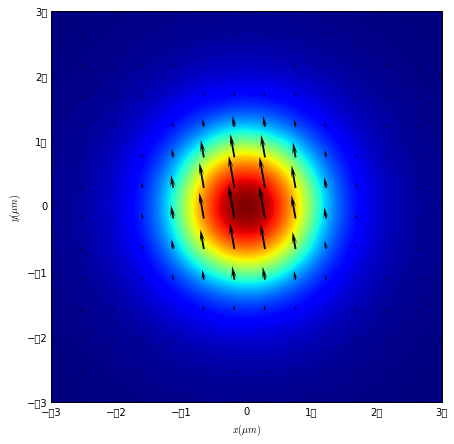

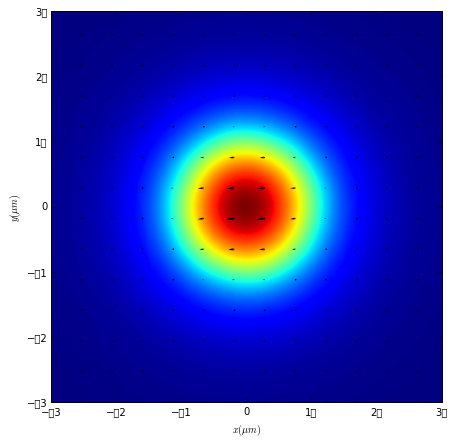

In [25]:
mode0.plot_electric_field(scales = 150000*2,sp=40,cont_scale=700)
mode1.plot_electric_field(scales = 150000*2,sp=40,cont_scale=700)